In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import jax
from jax import numpy as jnp
from jax import jit
import pennylane as qml
import optax
from scipy.integrate import trapezoid
import time
import pickle
import warnings
warnings.filterwarnings("ignore")
from scipy.special import comb

In [2]:
import pickle
from jax.lib import xla_bridge
jax.experimental.enable_x64()
print("JAX Backend:", xla_bridge.get_backend().platform)

JAX Backend: gpu


In [3]:
n_qubits = 4
n_ancillas = 4

total_qubits = n_qubits + n_ancillas
dev = qml.device("default.qubit",wires=total_qubits)

  
#QCBM Circuit - RZ + IsingXY + IsingZZ    
def qcbm_circuit(params,total_qubits):
    
    rz_params = params[:total_qubits]
    ising_params = params[total_qubits:]
    for i in range(total_qubits):
        qml.RZ(rz_params[i],wires=i)
    for i in range(total_qubits-1):
        qml.IsingXY(ising_params[i],wires=[i,i+1])
    qml.IsingXY(ising_params[total_qubits-1],wires=[total_qubits-1,0])
    for i in range(total_qubits-1):
        qml.IsingZZ(ising_params[i],wires=[i,i+1])
    qml.IsingZZ(ising_params[total_qubits-1],wires=[total_qubits-1,0])
    

@qml.qnode(dev, interface='jax')
def cat_circuit(input_params,num_qubits=n_qubits,ancilla_qubits=n_ancillas,total_qubits=total_qubits):

    #Random state for pretraining
    # uniform_init(num_qubits,distribution)
    qml.BasisState(jnp.zeros(total_qubits, dtype=jnp.int32), wires=list(range(total_qubits)))
    
    for i in range(total_qubits):
        if i%2 == 0:
            qml.X(i)
        
    for i in range(8):
        # qml.Barrier(range(total_qubits))
        qcbm_circuit(params=input_params[i],total_qubits=total_qubits)

    return qml.probs(wires=list(i for i in range(total_qubits) if i%2 == 0))

@qml.qnode(dev, interface='jax')
def anticat_circuit(input_params,num_qubits=n_qubits,ancilla_qubits=n_ancillas,total_qubits=total_qubits):

    #Random state for pretraining
    # uniform_init(num_qubits,distribution)
    qml.BasisState(jnp.zeros(total_qubits, dtype=jnp.int32), wires=list(range(total_qubits)))
    
    for i in range(total_qubits):
        if i%2 == 0:
            qml.X(i)
        
    for i in range(8):
        # qml.Barrier(range(total_qubits))
        qcbm_circuit(params=input_params[i],total_qubits=total_qubits)

    return qml.probs(wires=list(i for i in range(total_qubits) if i%2 != 0))


In [4]:
#Load the trained model

with open('/home/akashm/PROJECT/Hiwi_qml/qcbm/model_local_no_pretraining/data/4qubit_cat_model_checkpoint.pkl',"rb") as file:
    trained_params = pickle.load(file)

parameters = trained_params['parameters']
kl_divs = trained_params['divs']

print("Model loaded successfully")

Model loaded successfully


In [5]:
with open('/home/akashm/PROJECT/Hiwi_qml/qcbm/model_local_no_pretraining/data/4qubit_target_distribution.pkl',"rb") as file:
    target_distribution = pickle.load(file)


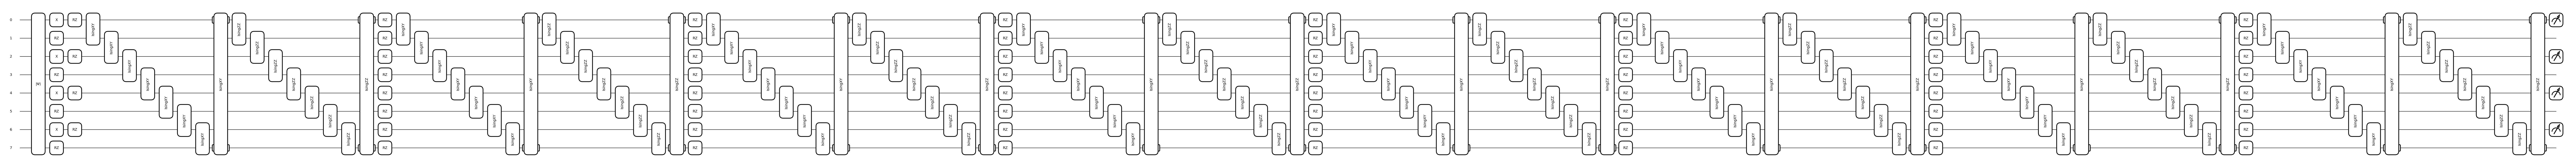

In [6]:
qml.draw_mpl(cat_circuit,device='default')(parameters[0])
plt.show()

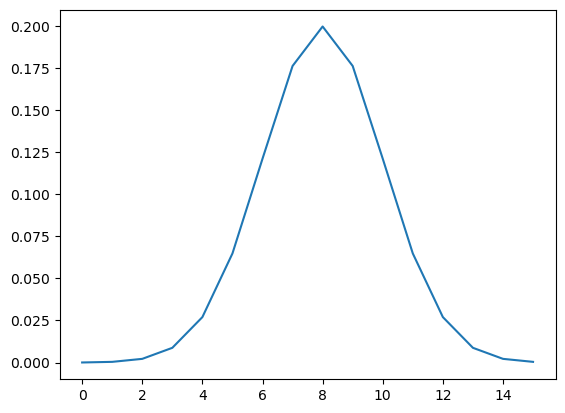

In [7]:
plt.plot(target_distribution)

Text(0, 0.5, 'Probability Distribution')

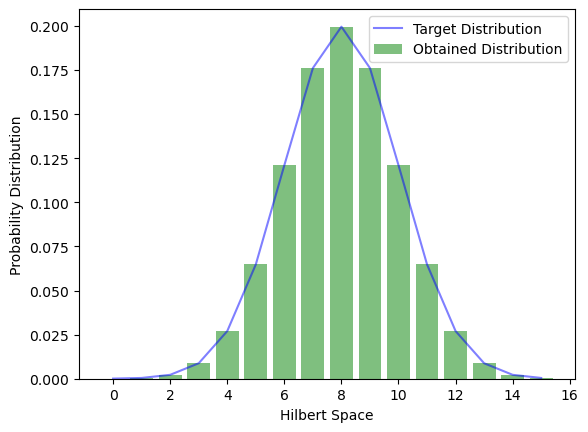

In [8]:
optimal_params = parameters[np.argmin(kl_divs)]

cat = cat_circuit(optimal_params)
x_array = jnp.arange(0,2**n_qubits,dtype=jnp.float64)
plt.plot(x_array,target_distribution,color='blue',alpha=0.5,label='Target Distribution')
plt.bar(x_array,cat,color='green',alpha=0.5,label='Obtained Distribution')
# plt.title("CAT Distribution")
plt.legend()
plt.xlabel('Hilbert Space')
plt.ylabel('Probability Distribution')

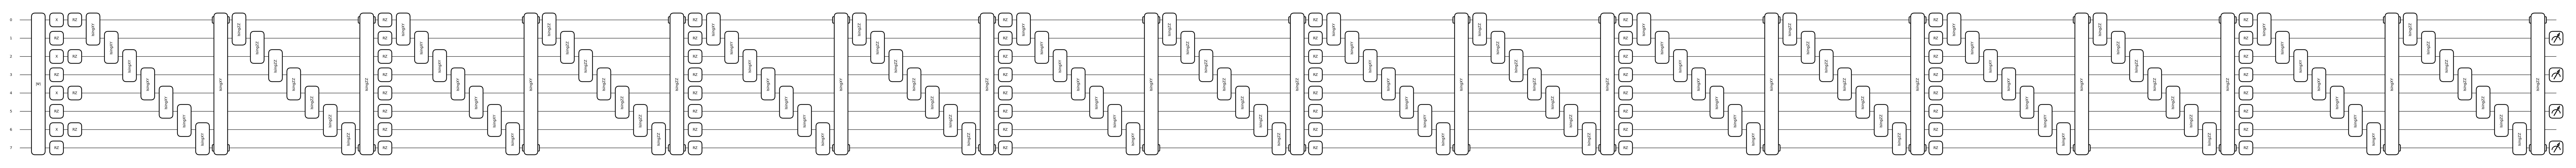

In [9]:
qml.draw_mpl(anticat_circuit,device='default')(parameters[0])
plt.show()

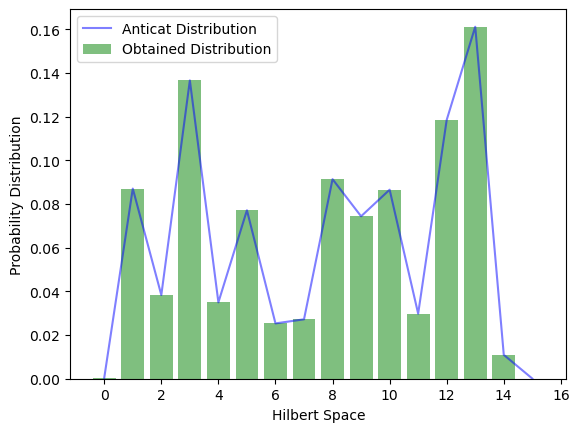

In [11]:
with open('/home/akashm/PROJECT/Hiwi_qml/qcbm/cat_anticat/data/4qubit_anticat_distribution.pkl',"rb") as file:
    target_distribution = pickle.load(file)

anti_cat = anticat_circuit(optimal_params)
plt.bar(x_array,anti_cat,color='green',alpha=0.5,label='Obtained Distribution')
plt.plot(x_array,target_distribution,color='blue',alpha=0.5,label='Anticat Distribution')
# plt.title("ANTI CAT")
plt.xlabel('Hilbert Space')
plt.ylabel('Probability Distribution')
plt.legend()

In [13]:
# Saving the AntiCat distribution
with open('/home/akashm/PROJECT/Hiwi_qml/qcbm/cat_anticat/data/4qubit_anticat_distribution.pkl',"wb") as file:
    pickle.dump(anti_cat,file)

print("AntiCat distribution saved successfully")

AntiCat distribution saved successfully
